In [1]:
#!pip download lifelines
#%pip install input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
#%pip install input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
#%pip install input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
#%pip install input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
#%pip install input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import rankdata 
import numpy as np
from tqdm import tqdm

import lightgbm as lgb
from lightgbm import LGBMRegressor

from scipy.stats import rankdata 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lifelines.utils import concordance_index
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb

from metric import score
import optuna
from typing import Dict, Tuple, Optional, List
import json

In [3]:
# set analysis output directory
def create_output_directory(output_path):
    """Create the output directory if it doesn't exist and set plotting style."""
    os.makedirs(output_path, exist_ok=True)
    return output_path

output_path = 'working/analysis'
create_output_directory(output_path)

'working/analysis'

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("input/data/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("input/data/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No           NaN       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No           NaN       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No           NaN       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0               NaN             NaN              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_issue pulm_severe  \
0            6.0       Bone marrow        No          No          No   
1            6.0  Peripheral blood        No          No          No   
2            6.0       Bone marrow        No          No          No   
3            6.0       Bone marrow        No          No          No   
4            6.0  Peripheral blood        No          No          No   

  prim_disease_hct  hla_high_res_6 cmv_status  hla_high_res_10  \
0              IEA             6.0        +/+              NaN   
1              AML             6.0        +/+             10.0   
2              HIS             6.0        +/+             10.0   
3              ALL             6.0        +/+             10.0   
4              MPN             6.0        +/+             10.0   

   hla_match_dqb1_high tce_imm_match  hla_nmdp_6  hla_match_c_low rituximab  \
0                  2.0           NaN         6.0              2.0        No   
1                  2.0           P/P         6.0              2.0        No   
2                  2.0           P/P         6.0              2.0        No   
3                  2.0           P/P         6.0              2.0        No   
4                  2.0           NaN         5.0              2.0        No   

   hla_match_drb1_low  hla_match_dqb1_low prod_type cyto_score_detail  \
0                 2.0                 2.0        BM               NaN   
1                 2.0                 2.0        PB      Intermediate   
2                 2.0                 2.0        BM               NaN   
3                 2.0                 2.0        BM      Intermediate   
4                 2.0                 2.0        PB               NaN   

  conditioning_intensity               ethnicity  year_hct obesity   mrd_hct  \
0                    NaN  Not Hispanic or Latino      2016      No       NaN   
1                    MAC  Not Hispanic or Latino      2008      No  Positive   
2                    NaN  Not Hispanic or Latino      2019      No       NaN   
3                    MAC  Not Hispanic or Latino      2009      No  Positive   
4                    MAC      Hispanic or Latino      2018      No       NaN   

  in_vivo_tcd   tce_match  hla_match_a_high hepatic_severe  donor_age  \
0         Yes         NaN               2.0             No        NaN   
1          No  Permissive               2.0             No      72.29   
2         Yes         NaN               2.0             No        NaN   
3          No  Permissive               2.0             No      29.23   
4         Yes         NaN               2.0             No      56.81   

  prior_tumor  hla_match_b_low peptic_ulcer  age_at_hct  hla_match_a_low  \
0          No              2.0           No       9.942              2.0   
1          No              2.0           No      43.705              2.0   
2          No              2.0           No      33.997              2.0   
3          No              2.0           No      43.245              2.0   
4          No              2.0           No      29.740              

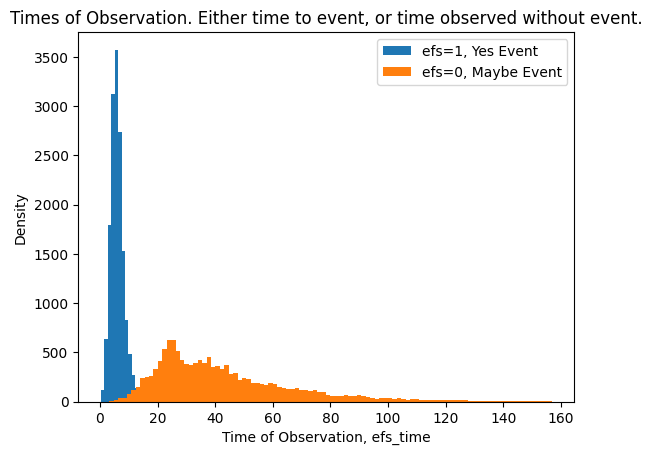

In [5]:
# Train targets
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.savefig(f'{output_path}times_of_observation.png')
plt.show()

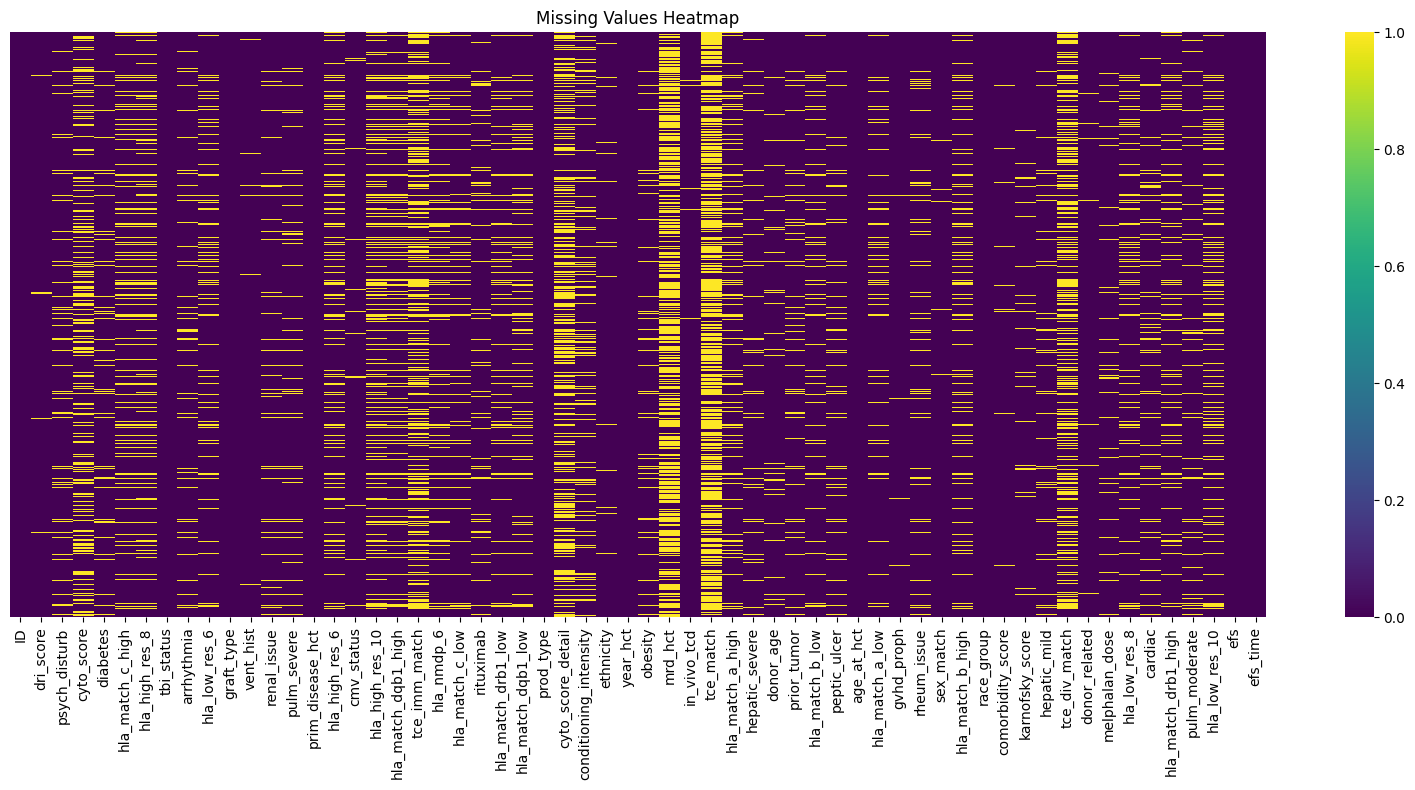

In [6]:
# missing values heatmap
def plot_missing_values_heatmap(df, output_path):
    plt.figure(figsize=(16, 8))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig(f'{output_path}/missing_values_heatmap.png')
    plt.show()
    plt.close()

plot_missing_values_heatmap(train, output_path)

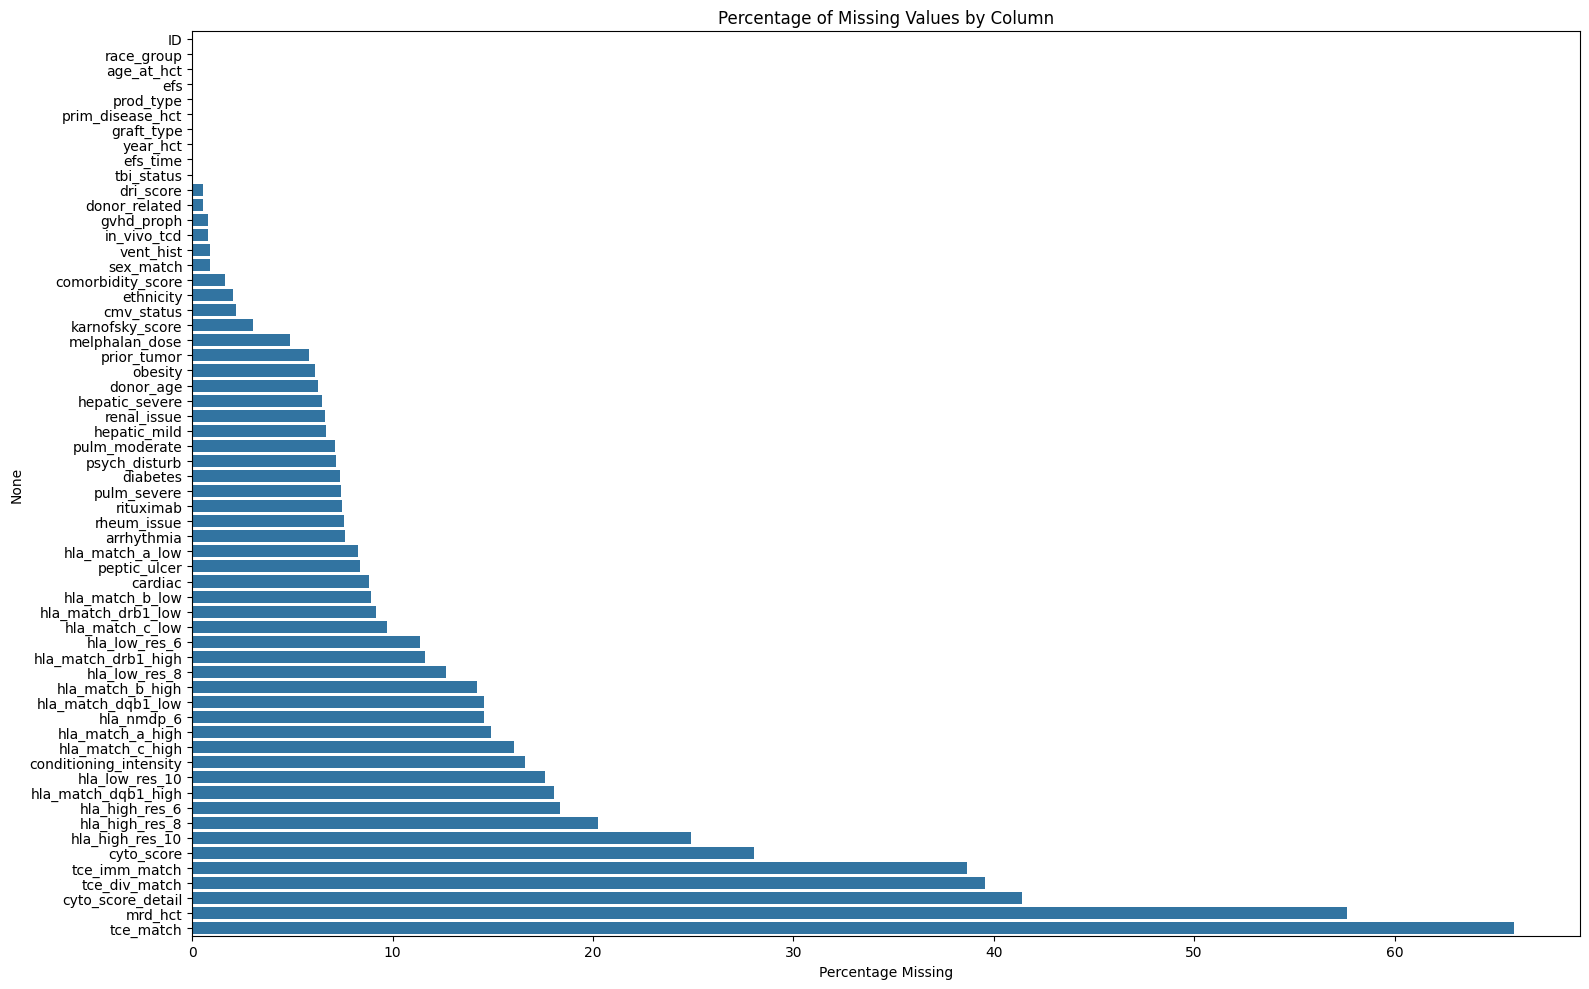

In [7]:
# missing value percentages
def plot_missing_values_bars(df, output_path):
    plt.figure(figsize=(16, 10))
    missing_percentages = (df.isnull().sum() / len(df) * 100).sort_values(ascending=True)
    sns.barplot(x=missing_percentages.values, y=missing_percentages.index)
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Percentage Missing')
    plt.tight_layout()
    plt.savefig(f'{output_path}/missing_values_percentage.png')
    plt.show()
    plt.close()

plot_missing_values_bars(train, output_path)

In [8]:
# numerical distributions
def plot_numerical_distributions(df, output_path):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    # Create progress bar for numerical distributions
    for col in tqdm(numerical_cols, desc="Creating distribution plots"):
        plt.figure(figsize=(10, 6))
        
        # Create subplot with histogram and kde
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        
        # Add statistical annotations
        stats_text = f'Mean: {df[col].mean():.2f}\n'
        stats_text += f'Median: {df[col].median():.2f}\n'
        stats_text += f'Std: {df[col].std():.2f}'
        plt.text(0.95, 0.95, stats_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'{output_path}/distribution_{col}.png')
        plt.close()

plot_numerical_distributions(train, output_path)

Creating distribution plots: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


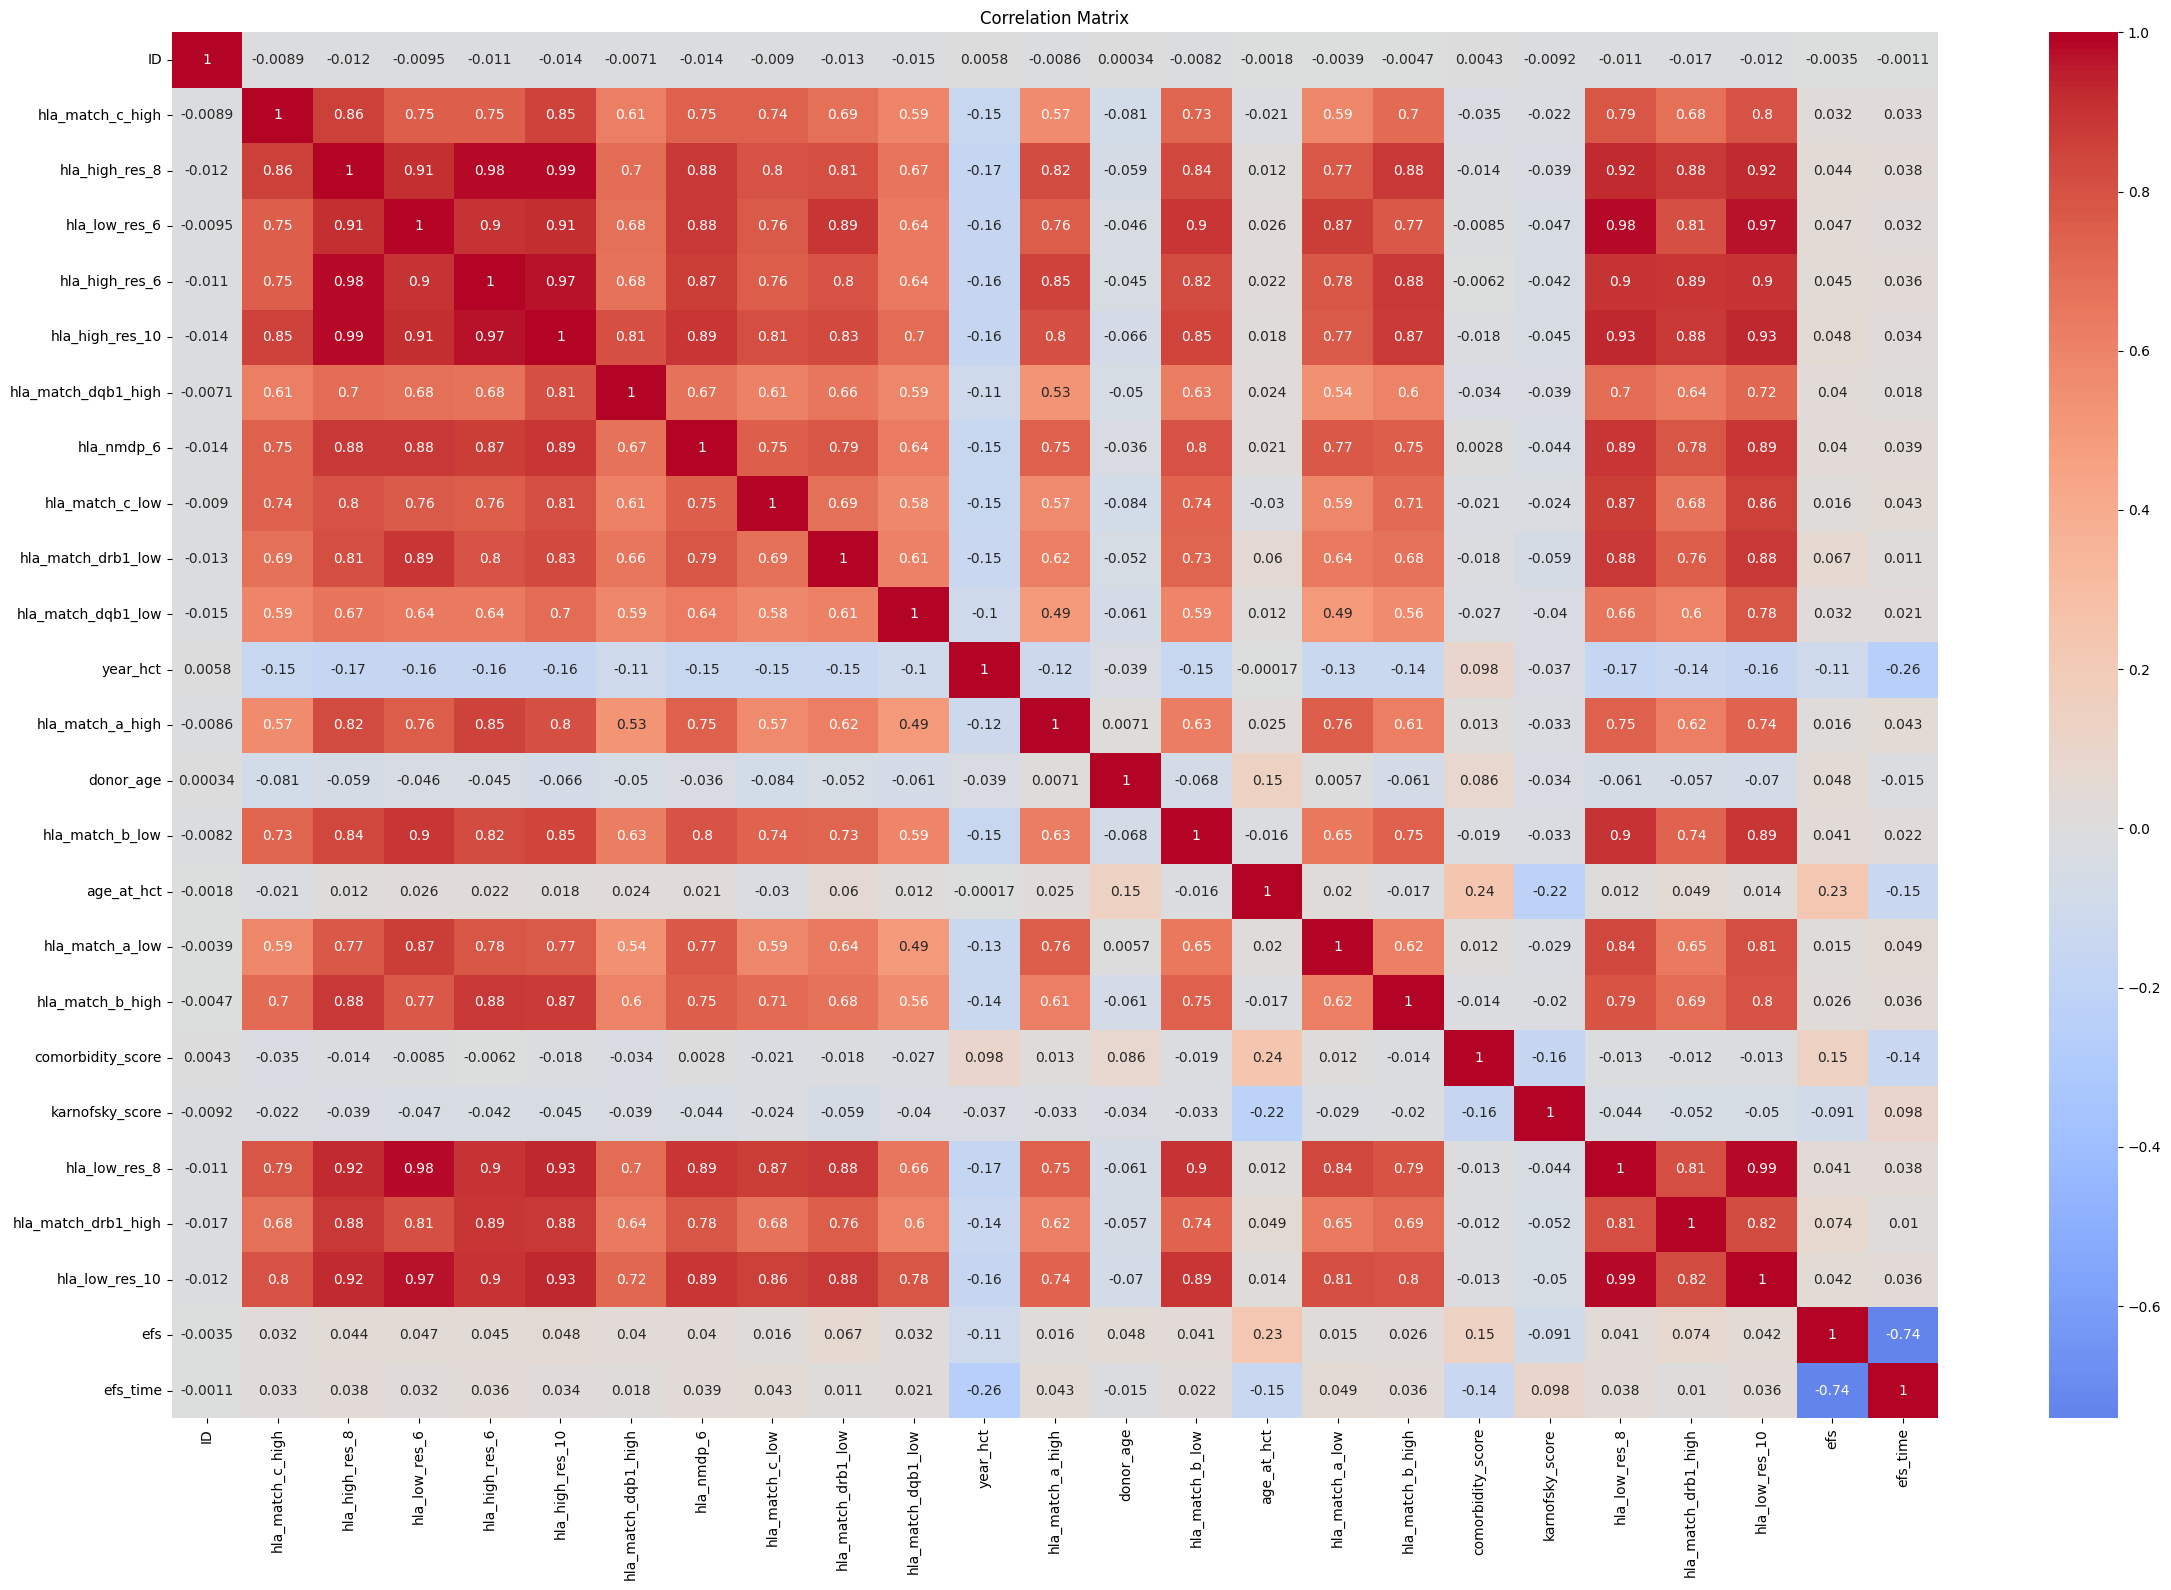

In [9]:
# correlation matrix
def plot_correlation_matrix(df, output_path):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    if len(numerical_cols) > 1:
        plt.figure(figsize=(24, 16))
        correlation_matrix = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.savefig(f'{output_path}/correlation_matrix.png')
        plt.show()
        plt.close()

plot_correlation_matrix(train, output_path)

In [10]:
# categorical distributions
def plot_categorical_distributions(df, output_path):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in tqdm(categorical_cols, desc="Creating categorical plots"):
        if df[col].nunique() < 30:
            plt.figure(figsize=(12, 6))
            value_counts = df[col].value_counts()
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(f'{output_path}/categorical_{col}.png')
            plt.close()

plot_categorical_distributions(train, output_path)

Creating categorical plots: 100%|██████████| 35/35 [00:04<00:00,  7.14it/s]


In [11]:
FEATURES = train.columns
print(f"Number of Features: {len(FEATURES)} FEATURES: {FEATURES}")

Number of Features: 60 FEATURES: Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_

In [12]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("Missing")
        test[c] = test[c].fillna("Missing")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [13]:
#imputer = KNNImputer(n_neighbors=101)
#numeric_cols = train[FEATURES].select_dtypes(include=['int32', 'float32', 'float64', 'int64']).columns
#imputed_data = imputer.fit_transform(train[numeric_cols])
#train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
#for col in train.columns:
#    if col not in numeric_cols:
#        train_imputed[col] = train[col]
        
#train = train_imputed

In [14]:
# Feature Engineering
def feature_engineering(df):   
    # Create age bins in 5-year intervals
    median_age = df['age_at_hct'].median()
    df['age_at_hct'] = df['age_at_hct'].replace([np.inf, -np.inf, '', None], np.nan).fillna(median_age)
    df['age_bin'] = pd.cut(df['age_at_hct'], 
                          bins=range(0, 95, 5),  # From 0 to 75 in steps of 5
                          labels=[f'{i}-{i+4}' for i in range(0, 90, 5)],
                          include_lowest=True)
    
    # commorbity by age at hct
    df['comorbidity_age'] = df['comorbidity_score'] * df['age_at_hct']
    
    df['age_bin_race'] = (df['age_bin'].astype(str) + '_' + 
                      df['race_group'].astype(str)).astype('category')

    # age x cyto
    df['cyto_age'] = (df['cyto_score_detail'].astype(str) + '_' + df['age_at_hct'].astype(str)).astype('category')

    # Concatenate graft_type and prod_type
    df['graft_prod'] = (df['graft_type'].astype(str) + '_' + 
                    df['prod_type'].astype(str)).astype('category')
    
    # Concatenate age bin and pulm severe
    df['age_bin_pulm_severe'] = (df['age_bin'].astype(str) + '_' + 
                    df['pulm_severe'].astype(str)).astype('category')
    
    # Concatenate age bin, race_group, and dri score
    df['age_bin_dri'] = (df['age_bin'].astype(str) + '_' + 
                    df['dri_score'].astype(str)).astype('category')

    # hla high mean
    df['hla_high_res_mean'] = df[['hla_high_res_8', 'hla_high_res_10', 'hla_high_res_6']].mean(axis=1)

    # hla low mean
    df['hla_low_res_mean'] = df[['hla_low_res_8', 'hla_low_res_10', 'hla_low_res_6']].mean(axis=1)

    # ration of hla high and hla low
    df['hla_ratio_res_highlow'] = (df['hla_high_res_mean']+1)/(df['hla_low_res_mean']+1)

    # ration of hla low and hla high
    df['hla_ratio_res_lowhigh'] = (df['hla_low_res_mean']+1)/(df['hla_high_res_mean']+1)

    # age functions
    df['donor_by_age_at_hct'] = (df['donor_age']/df['age_at_hct'])
    df['comorbidity_score_by_age_at_hct'] = (df['comorbidity_score']/df['age_at_hct'])
    
    # match drb
    df['hla_match_drb1_mean'] = df[['hla_match_drb1_high', 'hla_match_drb1_low']].mean(axis=1)

    # match dqb
    df['hla_match_dqb1_mean'] = df[['hla_match_dqb1_high', 'hla_match_dqb1_low']].mean(axis=1)

    # additional ratios
    df['hla_high_low_ratio'] = (df['hla_high_res_mean'] + 1) / (df['hla_low_res_mean'] + 1)
    df['drb1_dqb1_ratio'] = (df['hla_match_drb1_mean'] + 1) / (df['hla_match_dqb1_mean'] + 1)

    # difference in features
    df['high_low_diff'] = df['hla_high_res_mean'] - df['hla_low_res_mean']
    df['drb1_dqb1_diff'] = df['hla_match_drb1_mean'] - df['hla_match_dqb1_mean']

    # statistical aggregations
    df['hla_mean'] = df[['hla_high_res_mean', 'hla_low_res_mean', 'hla_match_drb1_mean', 'hla_match_dqb1_mean']].mean(axis=1)
    df['hla_std'] = df[['hla_high_res_mean', 'hla_low_res_mean', 'hla_match_drb1_mean', 'hla_match_dqb1_mean']].std(axis=1)
    df['hla_max'] = df[['hla_high_res_mean', 'hla_low_res_mean', 'hla_match_drb1_mean', 'hla_match_dqb1_mean']].max(axis=1)
    df['hla_min'] = df[['hla_high_res_mean', 'hla_low_res_mean', 'hla_match_drb1_mean', 'hla_match_dqb1_mean']].min(axis=1)

    # interaction terms
    df['drb1_high_interaction'] = df['hla_match_drb1_mean'] * df['hla_high_res_mean']
    df['dqb1_low_interaction'] = df['hla_match_dqb1_mean'] * df['hla_low_res_mean']

    # with or without TBI
    df['with_tbi'] = np.where((df['tbi_status']).astype(str) == 'No TBI', 'no', 'yes')

    # Create donor sex feature
    df['sex_donor'] = (df['sex_match']).astype(str).str[0]

    # Create recipient sex feature
    df['sex_recipient'] = (df['sex_match']).astype(str).str[2]

    # Main drug presence
    df['has_FK'] = (df['gvhd_proph']).astype(str).str.contains('FK', na=False).astype(int)
    df['has_MMF'] = (df['gvhd_proph']).astype(str).str.contains('MMF', na=False).astype(int)
    df['has_MTX'] = (df['gvhd_proph']).astype(str).str.contains('MTX', na=False).astype(int)
    df['has_CSA'] = (df['gvhd_proph']).astype(str).str.contains('CSA', na=False).astype(int)
    df['has_cyclophosphamide'] = (df['gvhd_proph']).astype(str).str.contains('Cyclophosphamide', na=False).astype(int)

    # Check for combination therapy
    df['has_combination'] = (df['gvhd_proph']).astype(str).str.contains('\+', na=False).astype(int)

    # Count number of agents (approximate by counting '+' signs)
    df['n_agents'] = (df['gvhd_proph']).astype(str).str.count('\+').add(1)

    # Complex vs Simple regimen
    df['is_complex'] = (df['gvhd_proph']).astype(str).str.contains('others', na=False).astype(int)

    # Depletion-based therapy
    df['is_depletion_based'] = (df['gvhd_proph']).astype(str).str.contains('TDEPLETION|CDselect', na=False).astype(int)

    # Monotherapy flag
    df['is_monotherapy'] = (df['gvhd_proph']).astype(str).str.contains('alone', na=False).astype(int)

    # No prophylaxis flag
    df['no_prophylaxis'] = ((df['gvhd_proph']).astype(str) == 'No GvHD Prophylaxis').astype(int)

    def get_primary_agent(x):
        if pd.isna(x):
            return 'Unknown'
        elif 'FK' in x:
            return 'FK-based'
        elif 'CSA' in x:
            return 'CSA-based'
        elif 'Cyclophosphamide' in x:
            return 'Cyclophosphamide-based'
        elif 'TDEPLETION' in x or 'CDselect' in x:
            return 'Depletion-based'
        else:
            return 'Other'

    df['primary_agent'] = (df['gvhd_proph']).astype(str).apply(get_primary_agent)

    # Standard vs Alternative approach
    df['is_standard_approach'] = (df['gvhd_proph']).astype(str).str.contains('FK\+ MMF|FK\+ MTX|CSA \+ MTX', na=False).astype(int)

    # Experimental/Other
    df['is_experimental'] = ((df['gvhd_proph']).astype(str) == 'Other GVHD Prophylaxis').astype(int)

    # Combine with other relevant features
    df['FK_MMF_interaction'] = df['has_FK'] * df['has_MMF']
    df['CSA_MTX_interaction'] = df['has_CSA'] * df['has_MTX']

    # karnofsky score
    median_karnofsky = df['karnofsky_score'].median()
    df['karnofsky_score'] = df['karnofsky_score'].replace([np.inf, -np.inf, '', None], np.nan).fillna(median_karnofsky)
    df['karnofsky_donor_comorbidity_age'] = (df['donor_by_age_at_hct']+df['comorbidity_score_by_age_at_hct']+1)/(df['karnofsky_score']+1)
    df['karnofsky_has_csa'] = df['karnofsky_score'] * df['has_CSA']
    df['karnofsky_is_depletion_based'] = df['karnofsky_score'] * df['is_depletion_based']
    df['karnofsky_is_monotherapy'] = df['karnofsky_score'] * df['is_monotherapy']
    df['karnofsky_age_at_hct'] = df['karnofsky_score'] * df['age_at_hct']
    df['karnofsky_comorbidity_score'] = df['karnofsky_score'] * df['comorbidity_score']
    df['graft_prod'] = df['graft_prod'].astype('category')
    
    return df

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

In [15]:
FEATURES = train.columns

In [16]:
# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

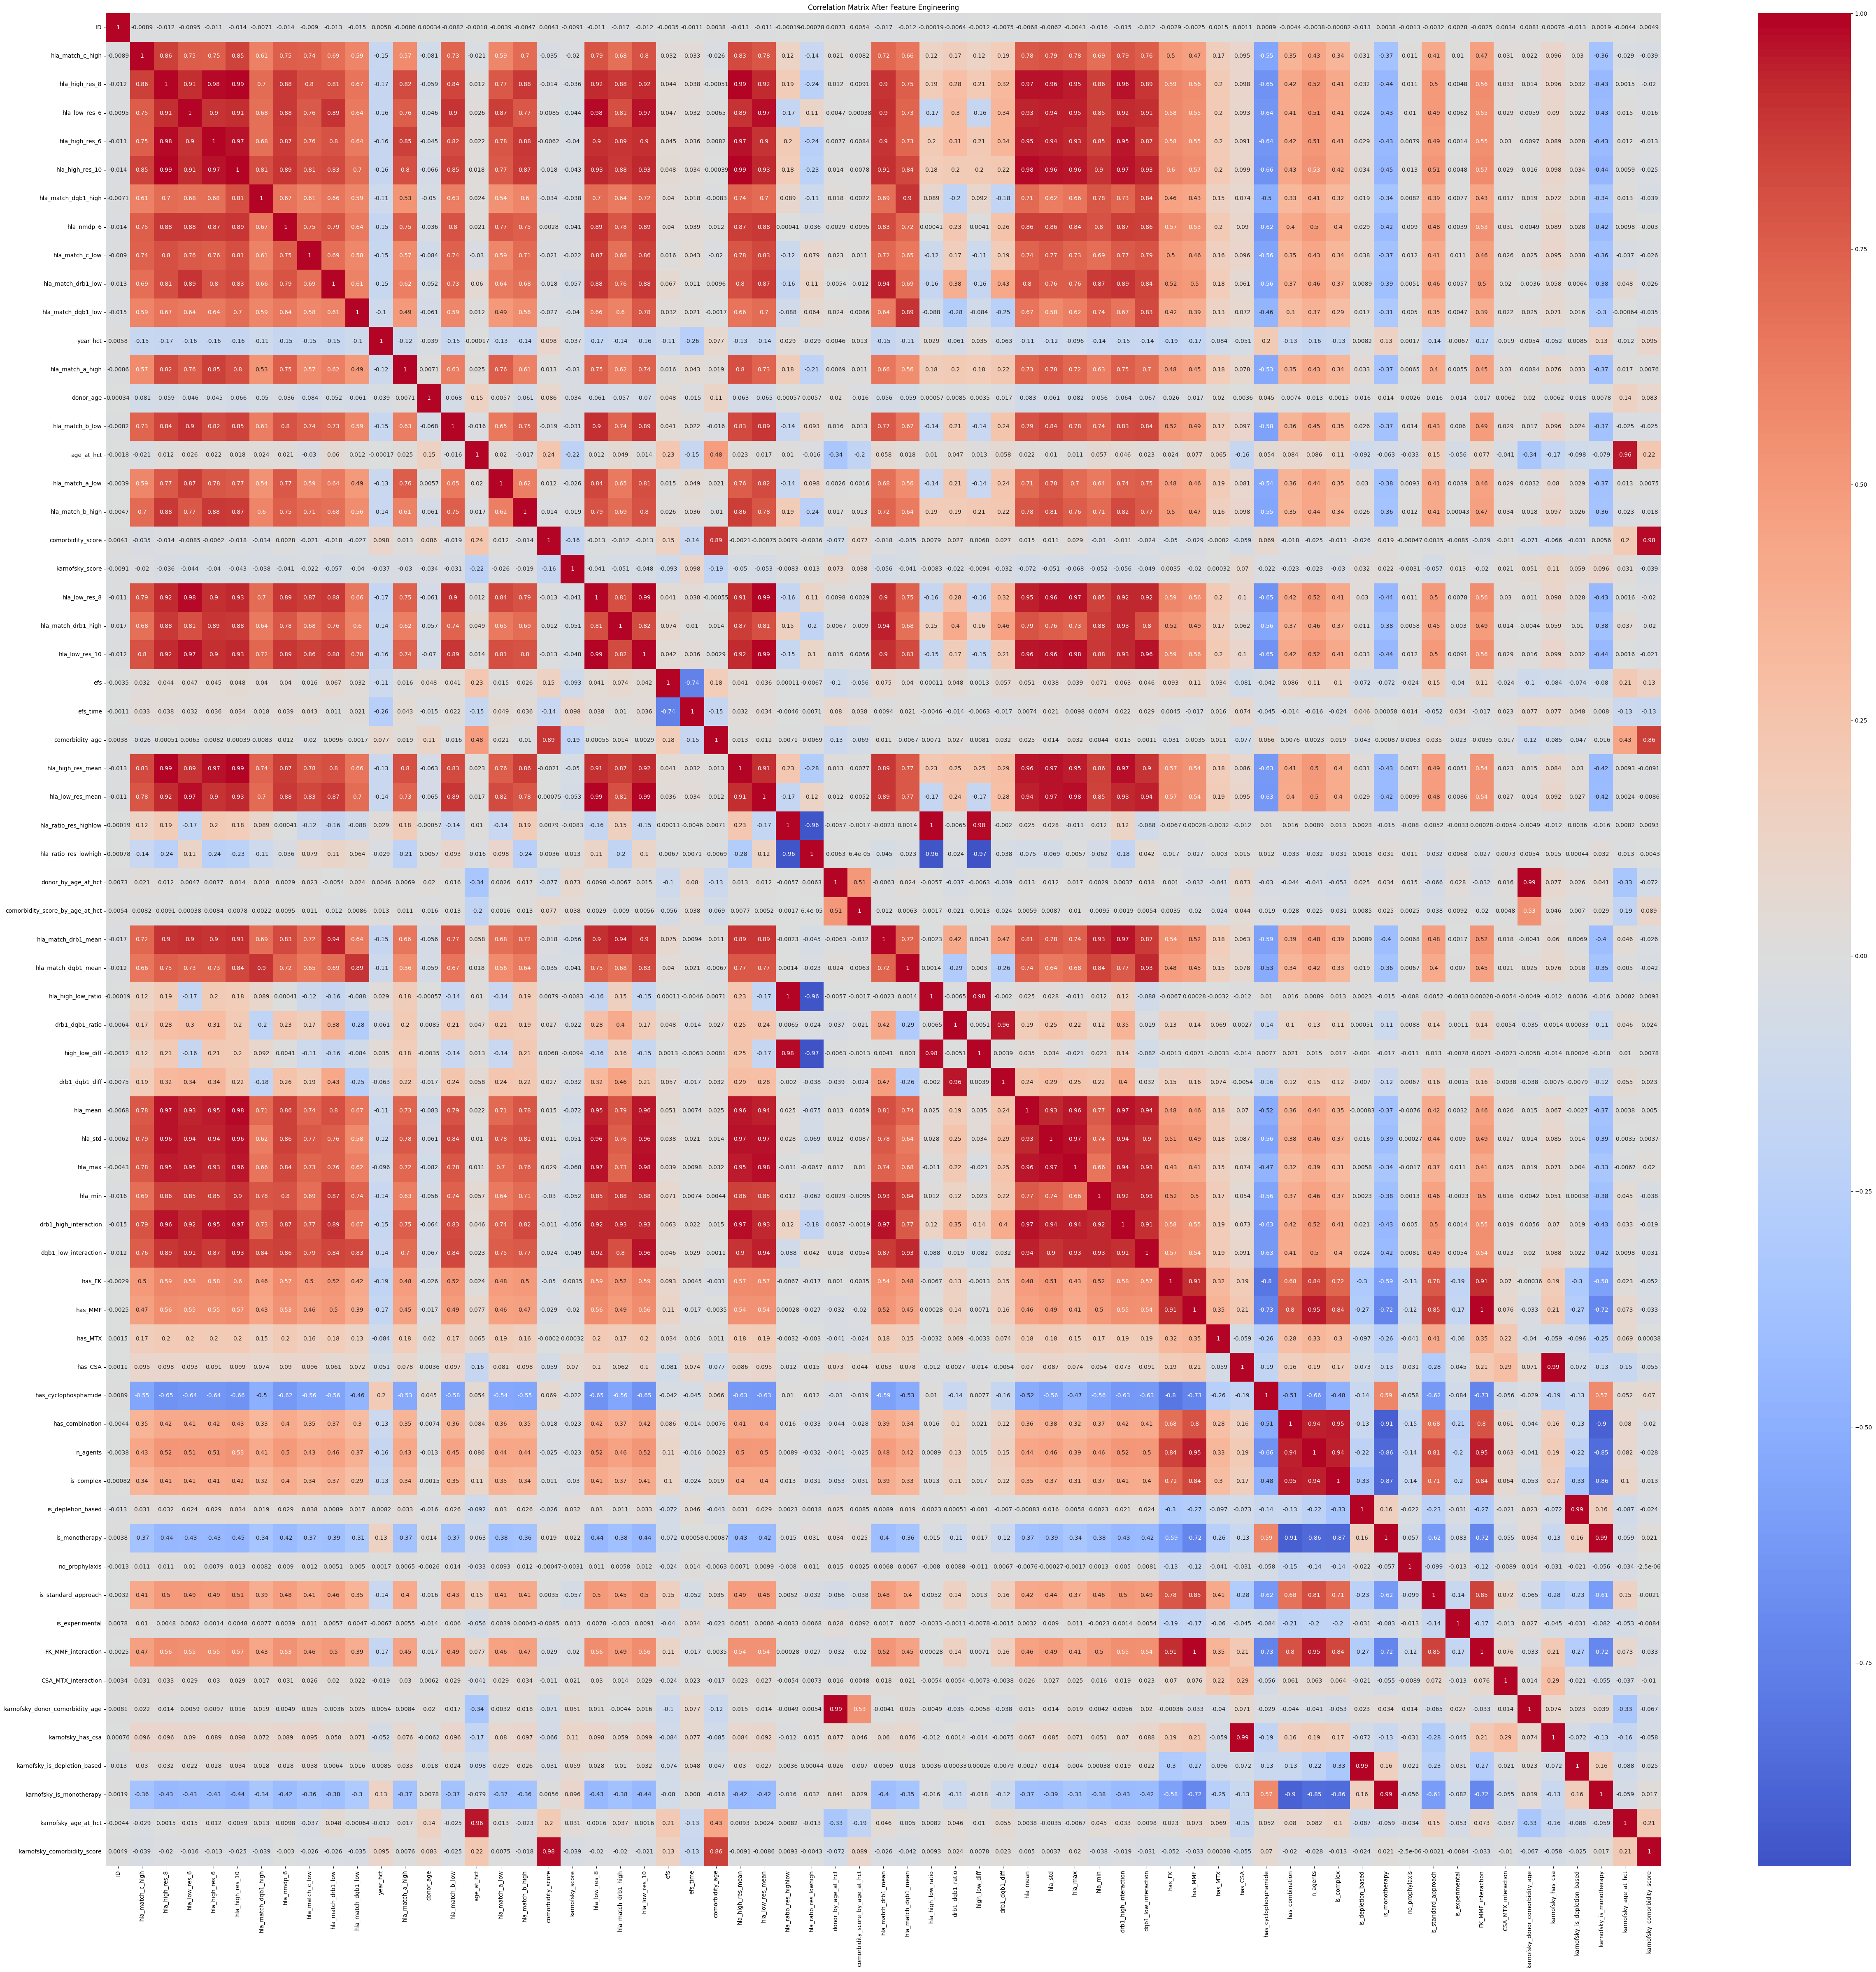

In [17]:
# correlation matrixn after feature engineering
def plot_correlation_matrix(df, output_path):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    if len(numerical_cols) > 1:
        plt.figure(figsize=(50, 48))
        correlation_matrix = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix After Feature Engineering')
        plt.tight_layout()
        plt.savefig(f'{output_path}/correlation_matrix_feature_engineering.png')
        plt.show()
        plt.close()

plot_correlation_matrix(train, output_path)

In [18]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, age_bin, age_bin_race, cyto_age, graft_prod, age_bin_pulm_severe, age_bin_dri, with_tbi, sex_donor, sex_recipient, primary_agent, 

In [19]:
for col in CATS:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

for col in CATS:
    # Ensure categories are coded as integers starting from 0
    train[col] = train[col].cat.codes
    test[col] = test[col].cat.codes
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    
    # Verify the encoding
    print(f"\nAfter fixing {col}:")
    print(train[col].value_counts())


After fixing dri_score:
dri_score
1     10436
5      4779
2      4701
0      2427
6      2003
3      1926
9      1414
7       481
4       272
10      198
8       154
11        9
Name: count, dtype: int64

After fixing psych_disturb:
psych_disturb
0    23005
2     3587
3     2062
1      146
Name: count, dtype: int64

After fixing cyto_score:
cyto_score
2    8802
0    8068
1    6376
4    3011
5    1341
6     643
3     504
7      55
Name: count, dtype: int64

After fixing diabetes:
diabetes
0    22201
1     4339
3     2119
2      141
Name: count, dtype: int64

After fixing tbi_status:
tbi_status
0    18861
2     6104
3     1727
1     1700
6      134
5      119
7       79
4       76
Name: count, dtype: int64

After fixing arrhythmia:
arrhythmia
0    25203
2     2202
1     1277
3      118
Name: count, dtype: int64

After fixing graft_type:
graft_type
1    20546
0     8254
Name: count, dtype: int64

After fixing vent_hist:
vent_hist
0    27721
1      820
2      259
Name: count, dtype: int64

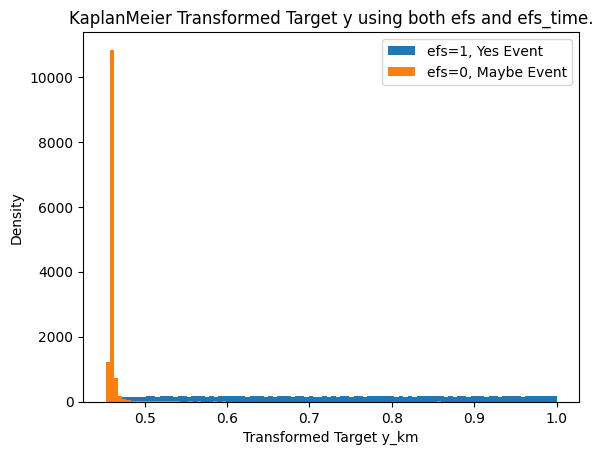

In [20]:
# Transform Two Targets into One Target with KaplanMeier
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
train["y_km"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

plt.hist(train.loc[train.efs==1,"y_km"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_km"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_km")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.savefig(f'{output_path}kaplanmeier_transformed_target_y.png')
plt.show()

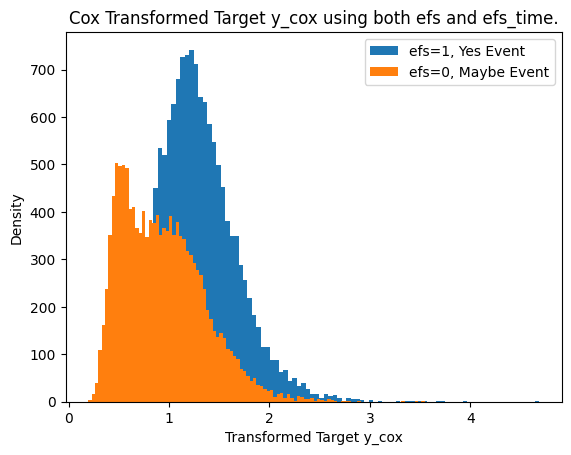

In [21]:
# Cox fitter
def transform_survival_probability(df):
    df = df.copy()
    df['efs_time'] = pd.to_numeric(df['efs_time'], errors='coerce')
    df['efs'] = pd.to_numeric(df['efs'], errors='coerce')
    required_cols = ['efs_time', 'efs'] + CATS
    df = df.dropna(subset=['efs_time', 'efs'])
    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(df[required_cols], duration_col='efs_time', event_col='efs')
    y = cph.predict_partial_hazard(df)
    return y
train["y_cox"] = transform_survival_probability(train)

plt.hist(train.loc[train.efs==1,"y_cox"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_cox"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_cox")
plt.ylabel("Density")
plt.title("Cox Transformed Target y_cox using both efs and efs_time.")
plt.legend()
plt.savefig(f'{output_path}cox_transformed_target_y.png')
plt.show()

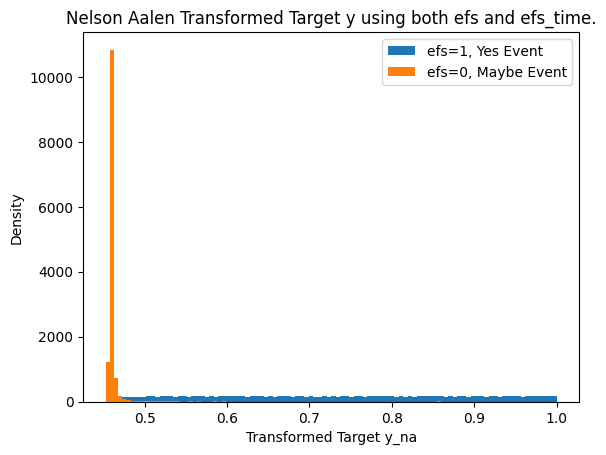

In [22]:
# NelsonAalenFitter
def transform_survival_probability(df):
    naf = NelsonAalenFitter()
    naf.fit(durations=df['efs_time'], event_observed=df['efs'])
    y = naf.cumulative_hazard_at_times(df['efs_time']).values
    y = y * -1
    return y
train["y_na"] = transform_survival_probability(train)

plt.hist(train.loc[train.efs==1,"y_km"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_km"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_na")
plt.ylabel("Density")
plt.title("Nelson Aalen Transformed Target y using both efs and efs_time.")
plt.legend()
plt.savefig(f'{output_path}nelsonaalen_transformed_target_y.png')
plt.show()

In [22]:
SEED = 9365

def perform_pca(train, test, n_components=None, random_state=42):
    # Remove rows with NaN values from both datasets
    train = train.dropna()
    test = test.dropna()

    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

In [ ]:
RMV = ["ID","efs","efs_time","y_cox", "y_km", "y_na"]

# PCA 
# Extract the numerical columns to be used in the PCA
train_num = train.drop(RMV, axis=1)
test_num = test.drop('ID', axis=1)

# Get numeric and categorical columns
numeric_columns = train_num.select_dtypes(include=['int32', 'float32']).columns
categorical_columns = train_num.select_dtypes(exclude=['int32', 'float32']).columns

# Split into numeric and categorical dataframes
train_numeric = train_num[numeric_columns]
test_numeric = test_num[numeric_columns]
train_categorical = train[categorical_columns]
test_categorical = test[categorical_columns]

# Scale the numeric columns
scaler = StandardScaler()
train_scaled = pd.DataFrame(
    scaler.fit_transform(train_numeric),
    columns=train_numeric.columns
)
test_scaled = pd.DataFrame(
    scaler.transform(test_numeric),
    columns=test_numeric.columns
)

train_pca, test_pca, pca = perform_pca(train_scaled, test_scaled, n_components=15, random_state=SEED)

train_rmv = train[RMV]

# Merge scaled numeric data with categorical data
train_final = pd.concat([train_scaled, train_categorical, train_pca, train_rmv], axis=1)
test_final = pd.concat([test_scaled, test_categorical, test_pca], axis=1)

In [24]:
test = test_final
train = train_final

FEATURES = train.columns

In [ ]:
FEATURES

In [ ]:
train.dtypes

In [ ]:
# XGBoost with KaplanMeier
print("Using XGBoost version",xgb.__version__)

In [28]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    #'PC_1',
    #'PC_2',
    #'PC_3',
    #'PC_4',
    #'PC_5',
    #'PC_6',
    #'PC_7',
    #'PC_8',
    #'PC_9',
    #'PC_10',
    #'PC_11',
    #'PC_12',
    #'PC_13',
    #'PC_14',
    #'PC_15',
    'comorbidity_age',
    'age_bin',
    'cyto_age',
    'graft_prod',
    'age_bin_race',
    'age_bin_pulm_severe',
    'hla_high_res_mean',
    'hla_low_res_mean',
    'hla_ratio_res_highlow',
    'hla_ratio_res_lowhigh',
    'age_bin_dri',
    'donor_by_age_at_hct',
    'comorbidity_score_by_age_at_hct',
    'hla_match_drb1_mean',
    'hla_match_dqb1_mean',
    'hla_high_low_ratio',
    'drb1_dqb1_ratio',
    'high_low_diff',
    'drb1_dqb1_diff',
    'hla_mean',
    'hla_std',
    'hla_max',
    'hla_min',
    'drb1_high_interaction',
    'dqb1_low_interaction',
    'with_tbi',
    'sex_donor',
    'sex_recipient',
    'has_FK',
    'has_MMF',
    'has_MTX',
    'has_CSA',
    'has_cyclophosphamide',
    'has_combination',
    'n_agents',
    'is_complex',
    'is_depletion_based',
    'is_monotherapy',
    'no_prophylaxis',
    'primary_agent',
    'is_standard_approach',
    'is_experimental',
    'FK_MMF_interaction',
    'CSA_MTX_interaction',
    'karnofsky_donor_comorbidity_age',
    'karnofsky_has_csa',
    'karnofsky_is_depletion_based',
    'karnofsky_is_monotherapy',
    'karnofsky_age_at_hct',
    'karnofsky_comorbidity_score'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [29]:
class XGBoostModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_xgb_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.3),
            'subsample': trial.suggest_float('subsample', 0.2, 0.9),
            'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 20, 120),
            'device': 'cuda',
            'enable_categorical': True
        }
        
        model = XGBRegressor(**param)
        model.fit(
            train_data[features], train_data['y_km'],
            eval_set=[(valid_data[features], valid_data['y_km'])],
            verbose=0
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, XGBRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_xgb: Predictions for test set
            - oof_xgb: Out-of-fold predictions for training set
            - xgb_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_xgb = np.zeros(len(train))
        pred_xgb = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(trial, train_fold, valid_fold, features),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'max_depth': 6,
                    'colsample_bytree': 0.5,
                    'subsample': 0.8,
                    'n_estimators': 2000,
                    'learning_rate': 0.01,
                    'min_child_weight': 80,
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_km']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_km']
            x_test = test[features]

            model_params = {
                **self.best_params,
                'device': 'cuda',
                'enable_categorical': True
            }
            
            model = XGBRegressor(**model_params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                verbose=500
            )
            
            if i == 0:
                best_model = model

            oof_xgb[valid_idx] = model.predict(x_valid)
            pred_xgb += model.predict(x_test)

        pred_xgb /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_xgb
        xgb_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {xgb_score}")
        
        return pred_xgb, oof_xgb, xgb_score, best_model

In [ ]:
# Initialize the model
xgb_model = XGBoostModel(n_folds=10, n_trials=200)

# For hyperparameter tuning:
pred_xgb, oof_xgb, xgb_score, model_xgb = xgb_model.train_and_predict(
    train, test, FEATURES, tune_hyperparameters=False
)

In [ ]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}xgboost_km_feature_importance.png')
plt.show()

In [ ]:
# CatBoost with KaplanMeier
print("Using CatBoost version",cb.__version__)

In [33]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    #'PC_1',
    #'PC_2',
    #'PC_3',
    #'PC_4',
    #'PC_5',
    #'PC_6',
    #'PC_7',
    #'PC_8',
    #'PC_9',
    #'PC_10',
    #'PC_11',
    #'PC_12',
    #'PC_13',
    #'PC_14',
    #'PC_15',
    'comorbidity_age',
    'age_bin',
    'cyto_age',
    'graft_prod',
    'age_bin_race',
    'age_bin_pulm_severe',
    'hla_high_res_mean',
    'hla_low_res_mean',
    'hla_ratio_res_highlow',
    'hla_ratio_res_lowhigh',
    'age_bin_dri',
    'donor_by_age_at_hct',
    'comorbidity_score_by_age_at_hct',
    'hla_match_drb1_mean',
    'hla_match_dqb1_mean',
    'hla_high_low_ratio',
    'drb1_dqb1_ratio',
    'high_low_diff',
    'drb1_dqb1_diff',
    'hla_mean',
    'hla_std',
    'hla_max',
    'hla_min',
    'drb1_high_interaction',
    'dqb1_low_interaction',
    'with_tbi',
    'sex_donor',
    'sex_recipient',
    'has_FK',
    'has_MMF',
    'has_MTX',
    'has_CSA',
    'has_cyclophosphamide',
    'has_combination',
    'n_agents',
    'is_complex',
    'is_depletion_based',
    'is_monotherapy',
    'no_prophylaxis',
    'primary_agent',
    'is_standard_approach',
    'is_experimental',
    'FK_MMF_interaction',
    'CSA_MTX_interaction',
    'karnofsky_donor_comorbidity_age',
    'karnofsky_has_csa',
    'karnofsky_is_depletion_based',
    'karnofsky_is_monotherapy',
    'karnofsky_age_at_hct',
    'karnofsky_comorbidity_score'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [34]:
class CatBoostModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_catboost_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list, cat_features: List[str]) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'task_type': 'GPU',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'grow_policy': trial.suggest_categorical('grow_policy', ['Lossguide']),
            'depth': trial.suggest_int('depth', 2, 8),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli']),
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'early_stopping_rounds': 50,
            'verbose': 0
        }
        
        # Handle special parameter dependencies
        if param['bootstrap_type'] == 'Bayesian':
            param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 10.0)
        
        model = CatBoostRegressor(**param)
        model.fit(
            train_data[features], train_data['y_km'],
            eval_set=(valid_data[features], valid_data['y_km']),
            cat_features=cat_features,
            verbose=0
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        cat_features: List[str],
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, CatBoostRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            cat_features: List of categorical feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_cat: Predictions for test set
            - oof_cat: Out-of-fold predictions for training set
            - cat_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_cat = np.zeros(len(train))
        pred_cat = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(
                    trial, train_fold, valid_fold, features, cat_features
                ),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            # Add fixed parameters
            self.best_params.update({
                'task_type': 'GPU',
                'early_stopping_rounds': 50
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'task_type': 'GPU',
                    'learning_rate': 0.01,
                    'grow_policy': 'Lossguide',
                    'depth': 6,
                    'min_data_in_leaf': 1,
                    'l2_leaf_reg': 3.0,
                    'random_strength': 1,
                    'n_estimators': 2000,
                    'bootstrap_type': 'Bernoulli',
                    'subsample': 0.8,
                    'early_stopping_rounds': 50
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_km']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_km']
            x_test = test[features]
            
            model = CatBoostRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=(x_valid, y_valid),
                cat_features=cat_features,
                verbose=250
            )
            
            if i == 0:
                best_model = model

            oof_cat[valid_idx] = model.predict(x_valid)
            pred_cat += model.predict(x_test)

        pred_cat /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_cat
        cat_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {cat_score}")
        
        return pred_cat, oof_cat, cat_score, best_model

In [ ]:
# Initialize the model
cat_model = CatBoostModel(n_folds=10, n_trials=200)

# For hyperparameter tuning:
pred_cat, oof_cat, cat_score, model_cat = cat_model.train_and_predict(
    train, test, FEATURES, CATS, tune_hyperparameters=False
)

In [ ]:
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}catboost_km_feature_importance.png')
plt.show()

In [ ]:
# LightGBM with KaplanMeier
print("Using LightGBM version",lgb.__version__)

In [38]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    #'PC_1',
    #'PC_2',
    #'PC_3',
    #'PC_4',
    #'PC_5',
    #'PC_6',
    #'PC_7',
    #'PC_8',
    #'PC_9',
    #'PC_10',
    #'PC_11',
    #'PC_12',
    #'PC_13',
    #'PC_14',
    #'PC_15',
    'comorbidity_age',
    'age_bin',
    'cyto_age',
    'graft_prod',
    'age_bin_race',
    'age_bin_pulm_severe',
    'hla_high_res_mean',
    'hla_low_res_mean',
    'hla_ratio_res_highlow',
    'hla_ratio_res_lowhigh',
    'age_bin_dri',
    'donor_by_age_at_hct',
    'comorbidity_score_by_age_at_hct',
    'hla_match_drb1_mean',
    'hla_match_dqb1_mean',
    'hla_high_low_ratio',
    'drb1_dqb1_ratio',
    'high_low_diff',
    'drb1_dqb1_diff',
    'hla_mean',
    'hla_std',
    'hla_max',
    'hla_min',
    'drb1_high_interaction',
    'dqb1_low_interaction',
    'with_tbi',
    'sex_donor',
    'sex_recipient',
    'has_FK',
    'has_MMF',
    'has_MTX',
    'has_CSA',
    'has_cyclophosphamide',
    'has_combination',
    'n_agents',
    'is_complex',
    'is_depletion_based',
    'is_monotherapy',
    'no_prophylaxis',
    'primary_agent',
    'is_standard_approach',
    'is_experimental',
    'FK_MMF_interaction',
    'CSA_MTX_interaction',
    'karnofsky_donor_comorbidity_age',
    'karnofsky_has_csa',
    'karnofsky_is_depletion_based',
    'karnofsky_is_monotherapy',
    'karnofsky_age_at_hct',
    'karnofsky_comorbidity_score'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [39]:
class LightGBMModel:
    def __init__(
        self,
        n_folds: int = 10,
        random_state: int = 42,
        n_trials: int = 50,
        best_params_path: str = 'best_lgb_params.json'
    ):
        self.n_folds = n_folds
        self.random_state = random_state
        self.n_trials = n_trials
        self.best_params_path = best_params_path
        self.best_params = None
        
    def objective(self, trial: optuna.Trial, train_data: pd.DataFrame, valid_data: pd.DataFrame,
                 features: list) -> float:
        """Optuna objective function for hyperparameter optimization."""
        param = {
            'device': 'gpu',
            'gpu_use_dp': True,
            'num_leaves': trial.suggest_int('num_leaves', 15, 63),
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.5),
            'subsample': trial.suggest_float('subsample', 0.2, 0.8),
            'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'objective': 'regression',
            'verbose': -1
        }
        
        model = LGBMRegressor(**param)
        model.fit(
            train_data[features], train_data['y_km'],
            eval_set=[(valid_data[features], valid_data['y_km'])]
        )
        
        predictions = model.predict(valid_data[features])
        
        # Create prediction DataFrame in required format
        y_true = valid_data[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = valid_data[["ID"]].copy()
        y_pred["prediction"] = predictions
        
        fold_score = score(y_true, y_pred, "ID")
        return fold_score
    
    def save_best_params(self, params: Dict) -> None:
        """Save the best parameters to a JSON file."""
        with open(self.best_params_path, 'w') as f:
            json.dump(params, f)
    
    def load_best_params(self) -> Optional[Dict]:
        """Load the best parameters from a JSON file if it exists."""
        if os.path.exists(self.best_params_path):
            with open(self.best_params_path, 'r') as f:
                return json.load(f)
        return None
    
    def train_and_predict(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        features: list,
        tune_hyperparameters: bool = False
    ) -> Tuple[np.ndarray, np.ndarray, float, LGBMRegressor]:
        """
        Train the model and make predictions, with optional hyperparameter tuning.
        
        Args:
            train: Training DataFrame
            test: Test DataFrame
            features: List of feature columns
            tune_hyperparameters: Whether to perform hyperparameter tuning
            
        Returns:
            Tuple containing:
            - pred_lgb: Predictions for test set
            - oof_lgb: Out-of-fold predictions for training set
            - lgb_score: Model score
            - best_model: Best trained model
        """
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        oof_lgb = np.zeros(len(train))
        pred_lgb = np.zeros(len(test))
        best_model = None

        if tune_hyperparameters:
            # Perform hyperparameter tuning on first fold
            print("Starting hyperparameter tuning...")
            train_idx, valid_idx = next(kf.split(train))
            
            # Create proper DataFrame splits for tuning
            train_fold = train.iloc[train_idx].copy()
            valid_fold = train.iloc[valid_idx].copy()
            
            study = optuna.create_study(direction='maximize')
            study.optimize(
                lambda trial: self.objective(trial, train_fold, valid_fold, features),
                n_trials=self.n_trials
            )
            
            self.best_params = study.best_params
            # Add fixed parameters
            self.best_params.update({
                'device': 'gpu',
                'gpu_use_dp': True,
                'objective': 'regression'
            })
            self.save_best_params(self.best_params)
            print(f"Best parameters: {self.best_params}")
        else:
            self.best_params = self.load_best_params()
            if self.best_params is None:
                print("No saved parameters found. Using default parameters.")
                self.best_params = {
                    'device': 'gpu',
                    'num_leaves': 31,
                    'max_depth': 3,
                    'colsample_bytree': 0.4,
                    'subsample': 0.8,
                    'n_estimators': 2500,
                    'learning_rate': 0.01,
                    'objective': 'regression',
                    'gpu_use_dp': True
                }

        # Train the model with best parameters
        for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
            print(f"Training fold {i+1}/{self.n_folds}")
            
            x_train = train.iloc[train_idx][features]
            y_train = train.iloc[train_idx]['y_km']
            x_valid = train.iloc[valid_idx][features]
            y_valid = train.iloc[valid_idx]['y_km']
            x_test = test[features]
            
            model = LGBMRegressor(**self.best_params)
            model.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)]
            )
            
            if i == 0:
                best_model = model

            oof_lgb[valid_idx] = model.predict(x_valid)
            pred_lgb += model.predict(x_test)

        pred_lgb /= self.n_folds
        
        # Calculate final score
        y_true = train[["ID", "efs", "efs_time", "race_group"]].copy()
        y_pred = train[["ID"]].copy()
        y_pred["prediction"] = oof_lgb
        lgb_score = score(y_true.copy(), y_pred.copy(), "ID")
        print(f"\nOverall CV Score: {lgb_score}")
        
        return pred_lgb, oof_lgb, lgb_score, best_model

In [ ]:
# Initialize the model
lgb_model = LightGBMModel(n_folds=10, n_trials=200)

# For hyperparameter tuning:
pred_lgb, oof_lgb, lgb_score, model_lgb = lgb_model.train_and_predict(
    train, test, FEATURES, tune_hyperparameters=False
)

In [ ]:
feature_importance = model_lgb.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}lightgbm_km_feature_importance.png')
plt.show()

In [42]:
# XGBoost with Survival:Cox
# SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [43]:
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    #'PC_1',
    #'PC_2',
    #'PC_3',
    #'PC_4',
    #'PC_5',
    #'PC_6',
    #'PC_7',
    #'PC_8',
    #'PC_9',
    #'PC_10',
    #'PC_11',
    #'PC_12',
    #'PC_13',
    #'PC_14',
    #'PC_15',
    'comorbidity_age',
    'age_bin',
    'cyto_age',
    'graft_prod',
    'age_bin_race',
    'age_bin_pulm_severe',
    'hla_high_res_mean',
    'hla_low_res_mean',
    'hla_ratio_res_highlow',
    'hla_ratio_res_lowhigh',
    'age_bin_dri',
    'donor_by_age_at_hct',
    'comorbidity_score_by_age_at_hct',
    'hla_match_drb1_mean',
    'hla_match_dqb1_mean',
    'hla_high_low_ratio',
    'drb1_dqb1_ratio',
    'high_low_diff',
    'drb1_dqb1_diff',
    'hla_mean',
    'hla_std',
    'hla_max',
    'hla_min',
    'drb1_high_interaction',
    'dqb1_low_interaction',
    'with_tbi',
    'sex_donor',
    'sex_recipient',
    'has_FK',
    'has_MMF',
    'has_MTX',
    'has_CSA',
    'has_cyclophosphamide',
    'has_combination',
    'n_agents',
    'is_complex',
    'is_depletion_based',
    'is_monotherapy',
    'no_prophylaxis',
    'primary_agent',
    'is_standard_approach',
    'is_experimental',
    'FK_MMF_interaction',
    'CSA_MTX_interaction',
    'karnofsky_donor_comorbidity_age',
    'karnofsky_has_csa',
    'karnofsky_is_depletion_based',
    'karnofsky_is_monotherapy',
    'karnofsky_age_at_hct',
    'karnofsky_comorbidity_score'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb_cox = np.zeros(len(train))
pred_xgb_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[FEATURES].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        objective='survival:cox',
        eval_metric='cox-nloglik',
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500  
    )
    
    # INFER OOF
    oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox /= FOLDS

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox
xgb_cox_score = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox =",xgb_cox_score)

In [ ]:
feature_importance = model_xgb_cox.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(20, 20))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}xgboost_cox_feature_importance.png')
plt.show()

In [47]:
# CatBoost with Survival:Cox
# feature selection
FEATURES = ['dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    #'hla_match_c_high',
    'hla_high_res_8',
    'tbi_status',
    'arrhythmia',
    'hla_low_res_6',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'prim_disease_hct',
    'hla_high_res_6',
    'cmv_status',
    'hla_high_res_10',
    'hla_match_dqb1_high',
    'tce_imm_match',
    'hla_nmdp_6',
    #'hla_match_c_low',
    'rituximab',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'ethnicity',
    'year_hct',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hla_match_a_high',
    'hepatic_severe',
    'donor_age',
    'prior_tumor',
    #'hla_match_b_low',
    'peptic_ulcer',
    'age_at_hct',
    'hla_match_a_low',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    #'hla_match_b_high',
    'race_group',
    'comorbidity_score',
    'karnofsky_score',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'hla_low_res_8',
    'cardiac',
    'hla_match_drb1_high',
    'pulm_moderate',
    'hla_low_res_10',
    #'PC_1',
    #'PC_2',
    #'PC_3',
    #'PC_4',
    #'PC_5',
    #'PC_6',
    #'PC_7',
    #'PC_8',
    #'PC_9',
    #'PC_10',
    #'PC_11',
    #'PC_12',
    #'PC_13',
    #'PC_14',
    #'PC_15',
    'comorbidity_age',
    'age_bin',
    'cyto_age',
    'graft_prod',
    'age_bin_race',
    'age_bin_pulm_severe',
    'hla_high_res_mean',
    'hla_low_res_mean',
    'hla_ratio_res_highlow',
    'hla_ratio_res_lowhigh',
    'age_bin_dri',
    'donor_by_age_at_hct',
    'comorbidity_score_by_age_at_hct',
    'hla_match_drb1_mean',
    'hla_match_dqb1_mean',
    'hla_high_low_ratio',
    'drb1_dqb1_ratio',
    'high_low_diff',
    'drb1_dqb1_diff',
    'hla_mean',
    'hla_std',
    'hla_max',
    'hla_min',
    'drb1_high_interaction',
    'dqb1_low_interaction',
    'with_tbi',
    'sex_donor',
    'sex_recipient',
    'has_FK',
    'has_MMF',
    'has_MTX',
    'has_CSA',
    'has_cyclophosphamide',
    'has_combination',
    'n_agents',
    'is_complex',
    'is_depletion_based',
    'is_monotherapy',
    'no_prophylaxis',
    'primary_agent',
    'is_standard_approach',
    'is_experimental',
    'FK_MMF_interaction',
    'CSA_MTX_interaction',
    'karnofsky_donor_comorbidity_age',
    'karnofsky_has_csa',
    'karnofsky_is_depletion_based',
    'karnofsky_is_monotherapy',
    'karnofsky_age_at_hct',
    'karnofsky_comorbidity_score'
    ]

# Get categorical columns from train features
CATS = train[FEATURES].select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat_cox = np.zeros(len(train))
pred_cat_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y_cox"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y_cox"]
    x_test = test[FEATURES].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function='RMSE',
        random_state=284,
        task_type='GPU',
        #subsample=0.85,
        iterations=1000, 
        learning_rate=0.019433226073386847, 
        depth=10, 
        l2_leaf_reg=0.49616136337391203, 
        border_count=241, 
        bagging_temperature=0.9497991156695006, 
        random_strength=8.222038848670854, 
        min_data_in_leaf=31, 
        leaf_estimation_iterations=3, 
        max_ctr_complexity=4

    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_cox[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox /= FOLDS

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox
cat_cox_score = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",cat_cox_score)

In [ ]:
feature_importance = model_cat_cox.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(22, 22))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Survival:Cox Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.savefig(f'{output_path}catboost_cox_feature_importance.png')
plt.show()

In [ ]:
print(f"\nxgb score =",xgb_score)
print(f"\ncat score =",cat_score)
print(f"\nlgb score =",lgb_score)
print(f"\nxgb score =",xgb_cox_score)
print(f"\ncat score =",cat_cox_score)

In [59]:
oof_preds = [
    oof_xgb,
    oof_cat,
    oof_lgb,
    oof_xgb_cox,
    oof_cat_cox
]

weights = [1.0, 4.0, 1.0, 3.0, 2.0]

In [60]:
ranked_oof_preds = np.array([rankdata(p) for p in oof_preds])

In [61]:
ensemble_oof_preds = np.sum([w * p for w, p in zip(weights, ranked_oof_preds)], axis=0)

In [ ]:
# Ensemble CAT and XGB and LGB
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = ensemble_oof_preds
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

In [63]:
preds = [
    pred_xgb,
    pred_cat,
    pred_lgb,
    pred_xgb_cox,
    pred_cat_cox
]

In [64]:
ranked_preds = np.array([rankdata(p) for p in preds])

In [65]:
ensemble_preds = np.sum([w * p for w, p in zip(weights, ranked_preds)], axis=0)

In [ ]:
sub = pd.read_csv("input/data/sample_submission.csv")

# Print individual model rankings with np.set_printoptions for full output
np.set_printoptions(threshold=np.inf)

# Combine rankings
sub.prediction = ensemble_preds

print("\nFinal ensemble scores:")
print(sub.prediction)

sub.to_csv("submission.csv", index=False)
print("\nSub shape:", sub.shape)
sub.head()